# **Filtering Parallel Dataset with Fine-Tuned LaBSE Model**

In [ ]:
from sentence_transformers import SentenceTransformer, util
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import torch

## **Loading Dataset**

In [ ]:
df = pd.read_csv("/content/ru-ckt_final.csv", sep=";")

# Verify column names
print(df.columns)

Index(['ru', 'ckt'], dtype='object')


In [ ]:
df

,ru,ckt
0,Кит и олень,Ръэв ынкъам ӄораны
1,"Олень шел по берегу моря, и кит крикнул:","Аӈӄачормэпы нылеӄин ӄораӈы, ръэв-ым аӈӄайпы ны..."
2,давай сразимся.,- Китаӄун мынтэйкэвмык.
3,Кто сильнее - ты или я?,Мэӈин эплеэн армаӈ вальын!
4,- Хорошо!,- Ээ!
...,...,...
69220,Фигуры уже были убраны с шахматной доски.,Чьумэт энмэч чьоматкоёлгэпы алва гэнлелинэт.
69221,Шахматы.,Чьумэт
69222,"о, это ещё шахматы!","А'мын анны, лымӈэ ынӄэнат чьумэт!"
69223,"заниматься спортом, тренироваться",Илюльэтык


## **Loading Fine-Tuned Model from Hugging Face**

In [ ]:
model = SentenceTransformer("HSE-Chukchi-NLP/LaBSE-russian-chukchi")

## **Preparing Embeddings**

In [ ]:
src_sentences = df["ckt"].astype(str).tolist()
tgt_sentences = df["ru"].astype(str).tolist()

src_embeddings = model.encode(src_sentences, convert_to_tensor=True, normalize_embeddings=True)
tgt_embeddings = model.encode(tgt_sentences, convert_to_tensor=True, normalize_embeddings=True)

## **Dataset Filtering Using Cosine Similarity**

In [ ]:
similarities = util.cos_sim(src_embeddings, tgt_embeddings)

In [ ]:
threshold = 0.4 # Manually adjusted based on desired data removal percentage
trash = []
filtered_rows = []
scores = []

for i in range(len(src_sentences)):
    score = similarities[i][i].item()
    scores.append(score)
    if score >= threshold:
        filtered_rows.append((src_sentences[i], tgt_sentences[i], score))
    else:
        trash.append((src_sentences[i], tgt_sentences[i], score))


filtered_df = pd.DataFrame(filtered_rows, columns=["ckt", "ru", "score"])

In [ ]:
filtered_df

,ckt,ru,score
0,Ръэв ынкъам ӄораны,Кит и олень,0.830291
1,"Аӈӄачормэпы нылеӄин ӄораӈы, ръэв-ым аӈӄайпы ны...","Олень шел по берегу моря, и кит крикнул:",0.831675
2,- Китаӄун мынтэйкэвмык.,давай сразимся.,0.605270
3,- Ээ!,- Хорошо!,0.924131
4,Мынтэйкэвмык!,Давай сразимся,0.709753
...,...,...,...
48937,Чьумэт энмэч чьоматкоёлгэпы алва гэнлелинэт.,Фигуры уже были убраны с шахматной доски.,0.728418
48938,Чьумэт,Шахматы.,0.762757
48939,"А'мын анны, лымӈэ ынӄэнат чьумэт!","о, это ещё шахматы!",0.729174
48940,Илюльэтык,"заниматься спортом, тренироваться",0.489790


In [ ]:
trash

[('Мэӈин эплеэн армаӈ вальын!',
  'Кто сильнее - ты или я?',
  0.30015426874160767),
 ('ӄынурым ръэвмыӈильыт.',
  'В одну ярангу собрались все взрослые, а в другую пошли двое мальчиков.',
  0.3732009828090668),
 ('Ынпыянвытым ымыльо мыӈэрагты гэлӄытръулинэт, рыпэт гантыгэватленат нэнэнэт.',
  'В яранге, где остались дети, над пологом висела голова росомахи.',
  0.367140531539917),
 ('Лыгэрак, миӈкы нувичвэтӄинэт ӈинӄэгти, ныймэтваӄэн ёрорасӄыткынкэӈ ӄэпэрин амлявтыйӈын - тайӈыквын.',
  'Это был амулет.',
  0.33550330996513367),
 ('Ейвэлӄэй гынтэквъи колтагэӈэты.',
  'Девочка-сиротка забралась под шкуру лахтака на пологе',
  0.3881235718727112),
 ('Ынӄорыым елийӈын пылыткук нэмэ лыгипэтлеӄэй аӈӄагты эквэтгъи.',
  'сейчас оно всех уничтожит.',
  0.20855078101158142),
 ('Ынпъоравэтльат тэӈыплыткук рагтыгъат.',
  'Одна девочка осталась на голове росомахи.',
  0.2610604763031006),
 ("Ейвэлӄэе э'йӈэвнинэт рэсӄивыльыт о'равэтльат. Рымӈылявнэнат, энмэн ръанотайӈа пирининэт авалёмкыльэнат тэнты

In [ ]:
trash_df = pd.DataFrame(trash, columns=["ckt", "ru", "score"])

Saving "junk" sentences for manual review

In [ ]:
trash_df.to_csv('trash_cosine_sim.csv', index=False, sep=';')

In [ ]:
trash_df

,ckt,ru,score
0,Люур тылянвык милютӄэе льунинэт галгат.,Заяц бежал домой,0.131407
1,Ынпъэгычгын гачакэта ялгыттэнмаквъэ.,"Волк, ворон и горный баран",0.020662
2,Эмэмӄут,Эмэмкут,-0.093226
3,"Этчи кытчынвэпы рултыгъи ӈэвъэн, льотываннэн к...",Присел.,0.143017
4,- ӄэйӈун ы'ръунтэтыркын ӄонырыым китъам ӄун эп...,Наверное обманывает ну посмотрим,-0.019982
...,...,...,...
18387,Рылгытиӈульын,Участвующий в игре старается притянуть к себе ...,-0.278517
18388,Рачвыӈтагын,Финиш,-0.017906
18389,ӄумъэрик,Шалить,-0.038277
18390,ӄумъэрин,Шалость,-0.028807


### **Data Distribution Plot**

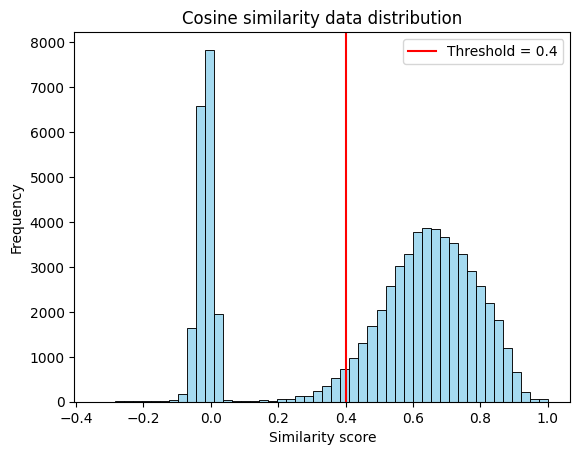

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(scores, bins=50, color='skyblue')
plt.axvline(threshold, color="red", label=f"Threshold = {threshold}")
plt.title("Cosine similarity data distribution")
plt.xlabel("Similarity score")
plt.ylabel("Frequency")
plt.legend()
plt.show()

The distribution shows a spike near 0. Manual inspection revealed these are dictionary entries containing word translations rather than full sentences. We'll preserve these dictionary entries during filtering.

### **Cosine Similarity Filtering v2**

Sorting by cosine similarity shows dictionary entries appear below 0.053

This code removes data with cosine similarity between 0.053 and 0.4

In [ ]:
threshold = 0.4
treshhold_dictionary = 0.053
dictionary = []
trash = []
filtered_rows = []
scores = []

for i in range(len(src_sentences)):
    score = similarities[i][i].item()
    scores.append(score)
    if score >= threshold:
        filtered_rows.append((src_sentences[i], tgt_sentences[i], score))
    elif score < treshhold_dictionary:
        dictionary.append((src_sentences[i], tgt_sentences[i], score))
    else:
        trash.append((src_sentences[i], tgt_sentences[i], score))


filtered_df = pd.DataFrame(filtered_rows, columns=["ckt", "ru", "score"])
dictionary_df = pd.DataFrame(dictionary, columns=["ckt", "ru", "score"])
trash_df = pd.DataFrame(trash, columns=["ckt", "ru", "score"])

In [ ]:
filtered_df

,ckt,ru,score
0,Ръэв ынкъам ӄораны,Кит и олень,0.830291
1,"Аӈӄачормэпы нылеӄин ӄораӈы, ръэв-ым аӈӄайпы ны...","Олень шел по берегу моря, и кит крикнул:",0.831675
2,- Китаӄун мынтэйкэвмык.,давай сразимся.,0.605270
3,- Ээ!,- Хорошо!,0.924131
4,Мынтэйкэвмык!,Давай сразимся,0.709753
...,...,...,...
48937,Чьумэт энмэч чьоматкоёлгэпы алва гэнлелинэт.,Фигуры уже были убраны с шахматной доски.,0.728418
48938,Чьумэт,Шахматы.,0.762757
48939,"А'мын анны, лымӈэ ынӄэнат чьумэт!","о, это ещё шахматы!",0.729174
48940,Илюльэтык,"заниматься спортом, тренироваться",0.489790


In [ ]:
dictionary_df

,ckt,ru,score
0,Ынпъэгычгын гачакэта ялгыттэнмаквъэ.,"Волк, ворон и горный баран",0.020662
1,Эмэмӄут,Эмэмкут,-0.093225
2,- ӄэйӈун ы'ръунтэтыркын ӄонырыым китъам ӄун эп...,Наверное обманывает ну посмотрим,-0.019982
3,Калеёӈав,Калеёнав,-0.048095
4,Эйпэӈэӈ,Эйпэнэн,-0.041463
...,...,...,...
18311,Рылгытиӈульын,Участвующий в игре старается притянуть к себе ...,-0.278517
18312,Рачвыӈтагын,Финиш,-0.017906
18313,ӄумъэрик,Шалить,-0.038277
18314,ӄумъэрин,Шалость,-0.028807


In [ ]:
trash_df

,ckt,ru,score
0,Мэӈин эплеэн армаӈ вальын!,Кто сильнее - ты или я?,0.300154
1,ӄынурым ръэвмыӈильыт.,"В одну ярангу собрались все взрослые, а в друг...",0.373201
2,"Ынпыянвытым ымыльо мыӈэрагты гэлӄытръулинэт, р...","В яранге, где остались дети, над пологом висел...",0.367141
3,"Лыгэрак, миӈкы нувичвэтӄинэт ӈинӄэгти, ныймэтв...",Это был амулет.,0.335503
4,Ейвэлӄэй гынтэквъи колтагэӈэты.,Девочка-сиротка забралась под шкуру лахтака на...,0.388123
...,...,...,...
1962,И'ӈыннупэтгъи,Погрузился до подъёма ноги.,0.268950
1963,Елырачвыӈгыргын въэнин ынкъам ръэвин,Состязание в красноречии корюшки с китом.,0.229842
1964,Тъаръылё гэринъытвинлин.,Несколько дней он старался улучшить свой бег.,0.353535
1965,Коргыӈ уйӈэ мытлёчет.,Нет ничего лучше тренировки.,0.381832


In [ ]:
trash_df.to_csv('trash_new.csv', sep=';', index=False)

In [ ]:
# filtered_df.to_csv("filtered_corpus.csv", sep=";", index=False)

### **Cosine Similarity Filtering v3**

This code removes data with cosine similarity between 0.053 and 0.4

The difference from v2 is that dictionary entries aren't saved to a separate dataframe - we get a filtered dataset containing both dictionary entries and parallel sentences with similarity > 0.4

In [ ]:
threshold = 0.4
treshhold_dictionary = 0.053
trash = []
merged = []
scores = []

for i in range(len(src_sentences)):
    score = similarities[i][i].item()
    scores.append(score)
    if score >= threshold:
        merged.append((src_sentences[i], tgt_sentences[i], score))
    elif score < treshhold_dictionary:
        merged.append((src_sentences[i], tgt_sentences[i], score))
    else:
        trash.append((src_sentences[i], tgt_sentences[i], score))


merged_df = pd.DataFrame(merged, columns=["ckt", "ru", "score"])
trash_df = pd.DataFrame(trash, columns=["ckt", "ru", "score"])

In [ ]:
merged_df

,ckt,ru,score
0,Ръэв ынкъам ӄораны,Кит и олень,0.830291
1,"Аӈӄачормэпы нылеӄин ӄораӈы, ръэв-ым аӈӄайпы ны...","Олень шел по берегу моря, и кит крикнул:",0.831675
2,- Китаӄун мынтэйкэвмык.,давай сразимся.,0.605270
3,- Ээ!,- Хорошо!,0.924131
4,Мынтэйкэвмык!,Давай сразимся,0.709753
...,...,...,...
67253,Чьумэт энмэч чьоматкоёлгэпы алва гэнлелинэт.,Фигуры уже были убраны с шахматной доски.,0.728418
67254,Чьумэт,Шахматы.,0.762757
67255,"А'мын анны, лымӈэ ынӄэнат чьумэт!","о, это ещё шахматы!",0.729174
67256,Илюльэтык,"заниматься спортом, тренироваться",0.489790


In [ ]:
trash_df

,ckt,ru,score
0,Мэӈин эплеэн армаӈ вальын!,Кто сильнее - ты или я?,0.300154
1,ӄынурым ръэвмыӈильыт.,"В одну ярангу собрались все взрослые, а в друг...",0.373201
2,"Ынпыянвытым ымыльо мыӈэрагты гэлӄытръулинэт, р...","В яранге, где остались дети, над пологом висел...",0.367141
3,"Лыгэрак, миӈкы нувичвэтӄинэт ӈинӄэгти, ныймэтв...",Это был амулет.,0.335503
4,Ейвэлӄэй гынтэквъи колтагэӈэты.,Девочка-сиротка забралась под шкуру лахтака на...,0.388123
...,...,...,...
1962,И'ӈыннупэтгъи,Погрузился до подъёма ноги.,0.268950
1963,Елырачвыӈгыргын въэнин ынкъам ръэвин,Состязание в красноречии корюшки с китом.,0.229842
1964,Тъаръылё гэринъытвинлин.,Несколько дней он старался улучшить свой бег.,0.353535
1965,Коргыӈ уйӈэ мытлёчет.,Нет ничего лучше тренировки.,0.381832


In [ ]:
merged_df.to_csv('ckt-ru_filtered.csv', index=False, sep=';')

In [ ]:
trash_df.to_csv('ckt-ru_trash.csv', index=False, sep=';')

## **Various Dataset Visualization Plots**

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Loading dataset
df = pd.read_csv('/content/ru-ckt_final.csv', sep=';')

In [ ]:
# Checking column names
print(df.columns)

In [ ]:
# Calculating sentence lengths in words
df['ru_len'] = df['ru'].astype(str).apply(lambda x: len(x.split()))
df['ckt_len'] = df['ckt'].astype(str).apply(lambda x: len(x.split()))

In [ ]:
max_len = max(df['ru_len'].max(), df['ckt_len'].max())

Index(['ru', 'ckt'], dtype='object')


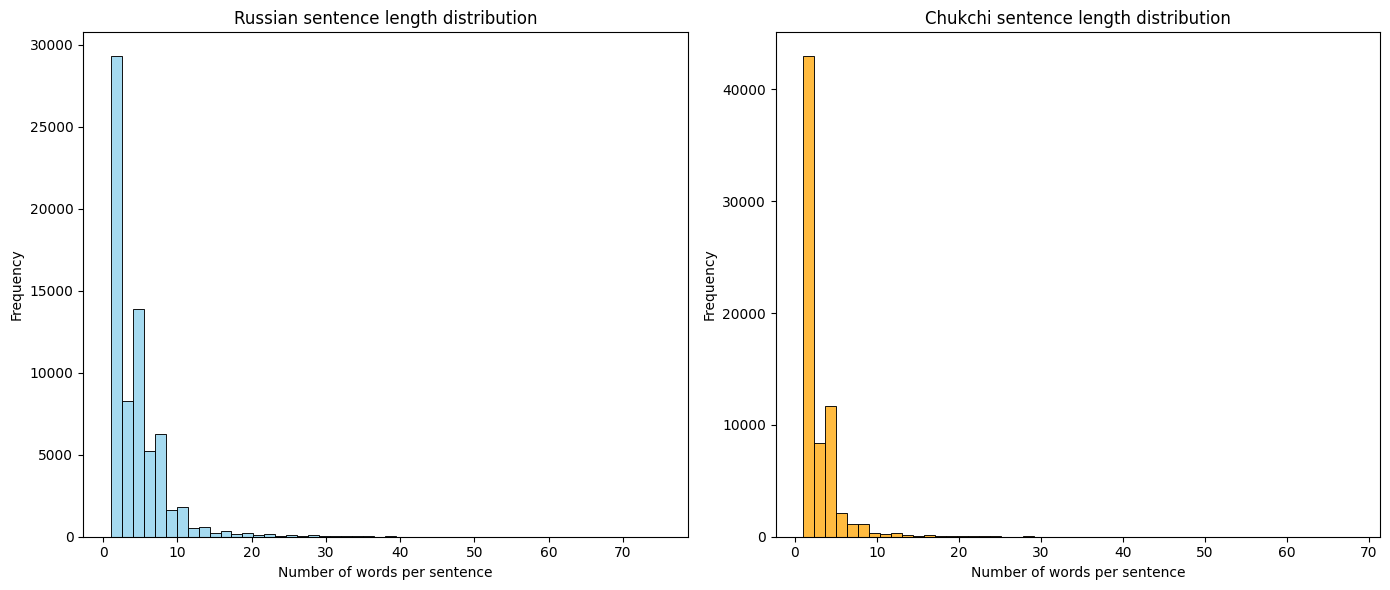

In [ ]:
plt.figure(figsize=(14, 6))

# Plot for Russian
plt.subplot(1, 2, 1)
sns.histplot(df['ru_len'], bins=50, color='skyblue')
plt.title('Russian sentence length distribution')
plt.xlabel('Number of words per sentence')
plt.ylabel('Frequency')

# Plot for Chukchi
plt.subplot(1, 2, 2)
sns.histplot(df['ckt_len'], bins=50, color='orange')
plt.title('Chukchi sentence length distribution')
plt.xlabel('Number of words per sentence')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

Index(['ru', 'ckt'], dtype='object')


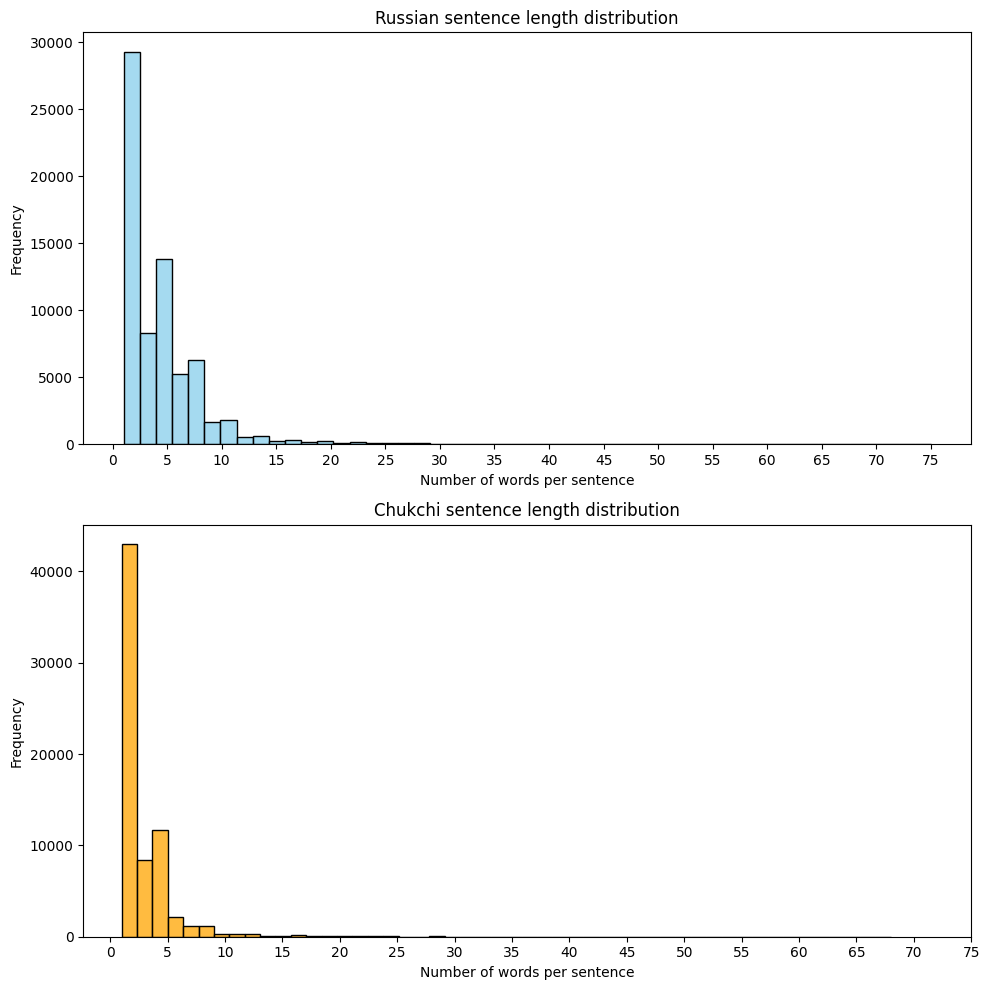

In [ ]:
plt.figure(figsize=(10, 10))

# Plot for Russian
plt.subplot(2, 1, 1)
sns.histplot(df['ru_len'], bins=50, color='skyblue')
plt.title('Russian sentence length distribution')
plt.xlabel('Number of words per sentence')
plt.ylabel('Frequency')
plt.xticks(ticks=range(0, max_len + 1, 5))

# Plot for Chukchi
plt.subplot(2, 1, 2)
sns.histplot(df['ckt_len'], bins=50, color='orange')
plt.title('Chukchi sentence length distribution')
plt.xlabel('Number of words per sentence')
plt.ylabel('Frequency')
plt.xticks(ticks=range(0, max_len + 1, 5))

plt.tight_layout()
plt.show()

In [ ]:
df['ckt_len'].sort_values(ascending=False)

,ckt_len
2189,68
3762,49
2121,48
4335,48
3464,47
...,...
27621,1
27620,1
43134,1
27619,1


## **Uploading Dataset to Hugging Face**

In [ ]:
!pip install huggingface_hub

In [ ]:
import pandas as pd

In [ ]:
df = pd.read_csv("/content/ru-ckt_final.csv", sep=";")
df.to_csv("ru_ckt_dataset/data.csv", index=False)

In [ ]:
from huggingface_hub import notebook_login
notebook_login()

In [ ]:
import os

In [ ]:
os.makedirs("ru_ckt_dataset", exist_ok=True)
os.system("cp /content/ru-ckt_final.csv ru_ckt_dataset/")

0

In [ ]:
from huggingface_hub import HfApi

api = HfApi()
api.create_repo(repo_id="HSE-Chukchi-NLP/russian-chukchi-parallel-corpora", repo_type="dataset", exist_ok=True)

api.upload_folder(
    folder_path="/content/ru_ckt_dataset",
    repo_id="HSE-Chukchi-NLP/russian-chukchi-parallel-corpora",
    repo_type="dataset"
)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


CommitInfo(commit_url='https://huggingface.co/datasets/HSE-Chukchi-NLP/russian-chukchi-parallel-corpora/commit/9b684f42095122fe9d8ef5885c1d86e62d3d2b6d', commit_message='Upload folder using huggingface_hub', commit_description='', oid='9b684f42095122fe9d8ef5885c1d86e62d3d2b6d', pr_url=None, repo_url=RepoUrl('https://huggingface.co/datasets/HSE-Chukchi-NLP/russian-chukchi-parallel-corpora', endpoint='https://huggingface.co', repo_type='dataset', repo_id='HSE-Chukchi-NLP/russian-chukchi-parallel-corpora'), pr_revision=None, pr_num=None)